## 1. Import Libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    roc_curve
)

# Settings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Constants
SEED = 42
N_SPLITS = 5

np.random.seed(SEED)

print("✓ Libraries imported successfully!")
print(f"Random Seed: {SEED}")
print(f"CV Folds: {N_SPLITS}")

✓ Libraries imported successfully!
Random Seed: 42
CV Folds: 5


## 2. Load and Explore Data

In [2]:
# Load datasets
train_df = pd.read_csv('train_heart.csv')
test_df = pd.read_csv('test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape:  {test_df.shape}")
print(f"\nTarget distribution:")
print(train_df['Heart Disease'].value_counts())
print(f"\nPercentage:")
print(train_df['Heart Disease'].value_counts(normalize=True) * 100)

train_df.head()

Train shape: (630000, 15)
Test shape:  (270000, 14)

Target distribution:
Heart Disease
Absence     347546
Presence    282454
Name: count, dtype: int64

Percentage:
Heart Disease
Absence     55.166032
Presence    44.833968
Name: proportion, dtype: float64


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [3]:
# Check for missing values
print("Missing values:")
print(train_df.isnull().sum())
print(f"\nTotal missing: {train_df.isnull().sum().sum()}")

# Data info
print("\n" + "="*60)
train_df.info()

Missing values:
id                         0
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

Total missing: 0

<class 'pandas.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              63

## 3. Exploratory Data Analysis

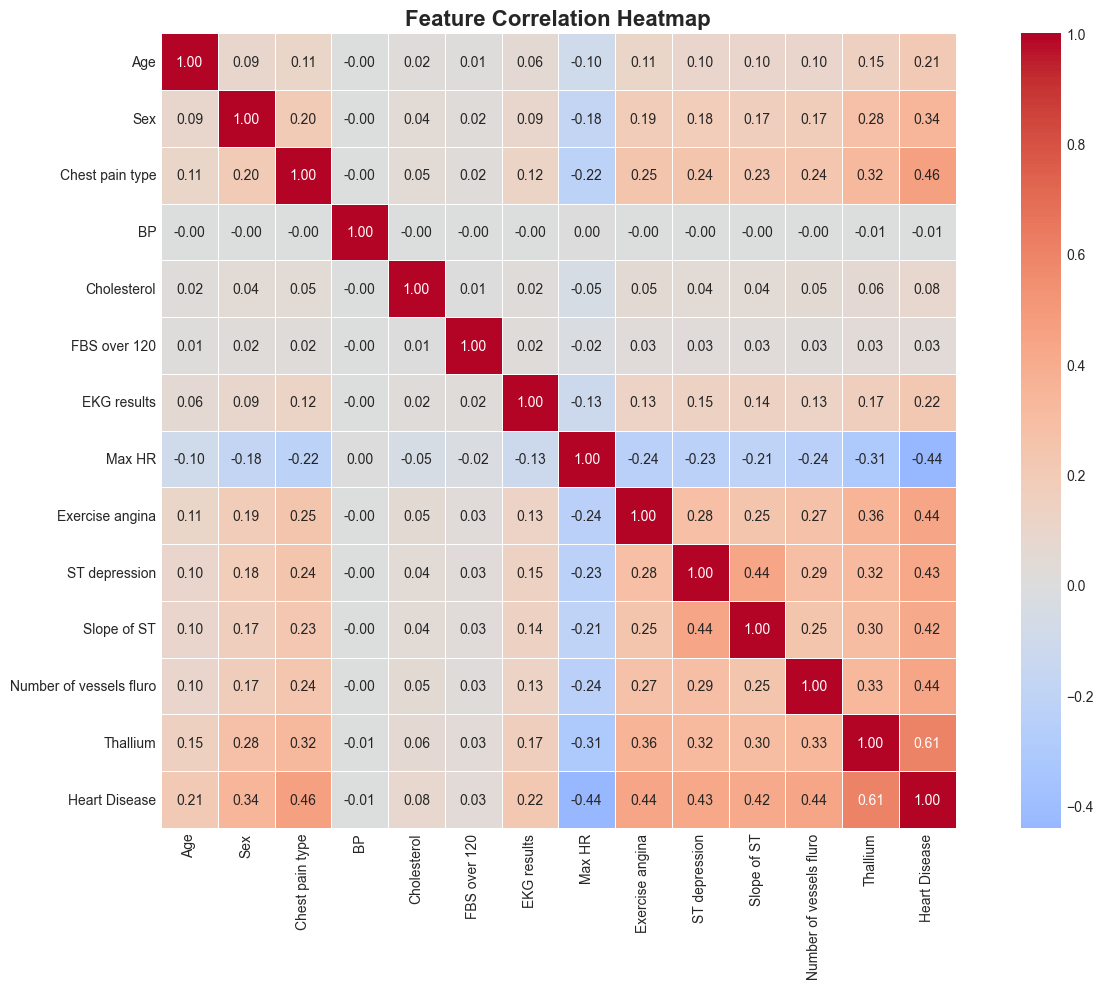


Top features correlated with Heart Disease:
Thallium                   0.605776
Chest pain type            0.460684
Exercise angina            0.441864
Max HR                    -0.440985
Number of vessels fluro    0.438604
ST depression              0.430641
Slope of ST                0.415050
Sex                        0.342446
EKG results                0.218961
Age                        0.212091
Name: Heart Disease, dtype: float64


In [4]:
# Correlation heatmap
df_corr = train_df.copy()
df_corr['Heart Disease'] = df_corr['Heart Disease'].map({'Presence': 1, 'Absence': 0})

plt.figure(figsize=(14, 10))
correlation_matrix = df_corr.drop('id', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Top correlations with target
target_corr = correlation_matrix['Heart Disease'].drop('Heart Disease').sort_values(key=abs, ascending=False)
print("\nTop features correlated with Heart Disease:")
print(target_corr.head(10))

## 4. Advanced Feature Engineering

Create interaction and derived features to improve model performance

In [6]:
def create_features(df):
    """Create advanced features for better model performance"""
    
    df = df.copy()
    
    # === INTERACTION FEATURES ===
    # Multiply important features to capture interactions
    df['age_cholesterol'] = df['Age'] * df['Cholesterol']
    df['bp_age'] = df['BP'] * df['Age']
    df['vessels_thallium'] = df['Number of vessels fluro'] * df['Thallium']
    df['chest_pain_vessels'] = df['Chest pain type'] * df['Number of vessels fluro']
    df['chest_pain_thallium'] = df['Chest pain type'] * df['Thallium']
    
    # === RATIO FEATURES ===
    # Create ratios to normalize by age or other factors
    df['hr_age_ratio'] = df['Max HR'] / (df['Age'] + 1)
    df['cholesterol_age_ratio'] = df['Cholesterol'] / (df['Age'] + 1)
    df['bp_age_ratio'] = df['BP'] / (df['Age'] + 1)
    df['st_depression_age_ratio'] = df['ST depression'] / (df['Age'] + 1)
    
    # === COMPOSITE RISK SCORES ===
    # Weighted combinations of risk factors
    df['heart_risk_score'] = (
        df['Thallium'] * 3 + 
        df['Chest pain type'] * 2 + 
        df['Number of vessels fluro'] * 2 +
        df['ST depression'] * 1.5
    )
    
    df['cardiac_stress_index'] = (
        df['Max HR'] * df['ST depression'] / (df['Age'] + 1)
    )
    
    # === POLYNOMIAL FEATURES ===
    # Square of important features
    df['age_sq'] = df['Age'] ** 2
    df['thallium_sq'] = df['Thallium'] ** 2
    df['chest_pain_sq'] = df['Chest pain type'] ** 2
    df['vessels_sq'] = df['Number of vessels fluro'] ** 2
    
    # === BINNED FEATURES ===
    # Age groups (range: 29-77, bins cover all values)
    df['age_group'] = pd.cut(df['Age'], bins=[0, 40, 50, 60, 100], labels=[0, 1, 2, 3])
    df['age_group'] = df['age_group'].fillna(1).astype(int)  # Fill any NaN with middle group
    
    # Cholesterol groups (range: 126-564, extended bins)
    df['cholesterol_group'] = pd.cut(df['Cholesterol'], bins=[0, 200, 240, 300, 1000], labels=[0, 1, 2, 3])
    df['cholesterol_group'] = df['cholesterol_group'].fillna(2).astype(int)
    
    # BP groups (range: 94-200, adjusted bins)
    df['bp_group'] = pd.cut(df['BP'], bins=[0, 120, 140, 180, 300], labels=[0, 1, 2, 3])
    df['bp_group'] = df['bp_group'].fillna(2).astype(int)
    
    return df

# Apply feature engineering
print("Creating features...")
train_engineered = create_features(train_df)
test_engineered = create_features(test_df)

# Encode target
train_engineered['Heart Disease'] = train_engineered['Heart Disease'].map({'Presence': 1, 'Absence': 0})

# Prepare features
X = train_engineered.drop(['id', 'Heart Disease'], axis=1)
y = train_engineered['Heart Disease']
X_test = test_engineered.drop('id', axis=1)
test_ids = test_engineered['id']

print(f"\n✓ Feature engineering complete!")
print(f"  Original features: 13")
print(f"  Total features: {len(X.columns)}")
print(f"  New features added: {len(X.columns) - 13}")
print(f"\n  Training samples: {len(X)}")
print(f"  Test samples: {len(X_test)}")

Creating features...

✓ Feature engineering complete!
  Original features: 13
  Total features: 31
  New features added: 18

  Training samples: 630000
  Test samples: 270000


In [7]:
# Display new features
print("All features:")
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")

All features:
 1. Age
 2. Sex
 3. Chest pain type
 4. BP
 5. Cholesterol
 6. FBS over 120
 7. EKG results
 8. Max HR
 9. Exercise angina
10. ST depression
11. Slope of ST
12. Number of vessels fluro
13. Thallium
14. age_cholesterol
15. bp_age
16. vessels_thallium
17. chest_pain_vessels
18. chest_pain_thallium
19. hr_age_ratio
20. cholesterol_age_ratio
21. bp_age_ratio
22. st_depression_age_ratio
23. heart_risk_score
24. cardiac_stress_index
25. age_sq
26. thallium_sq
27. chest_pain_sq
28. vessels_sq
29. age_group
30. cholesterol_group
31. bp_group


## 5. Optimized XGBoost with Cross-Validation

In [8]:
# Competition-level hyperparameters
xgb_params = {
    'n_estimators': 2000,           # More trees (with early stopping)
    'learning_rate': 0.02,          # Lower learning rate for better performance
    'max_depth': 6,                 # Optimal tree depth
    'subsample': 0.85,              # Sample 85% of data for each tree
    'colsample_bytree': 0.85,       # Sample 85% of features
    'colsample_bylevel': 0.85,      # Feature sampling at each level
    'min_child_weight': 3,          # Minimum sum of weights in child
    'gamma': 0.1,                   # Minimum loss reduction
    'reg_alpha': 0.1,               # L1 regularization
    'reg_lambda': 2.0,              # L2 regularization
    'random_state': SEED,
    'n_jobs': -1,                   # Use all CPU cores
    'eval_metric': 'auc',           # ROC-AUC metric
    'tree_method': 'hist',          # Fast histogram-based algorithm
    'early_stopping_rounds': 100    # Stop if no improvement
}

print("XGBoost Hyperparameters:")
print("="*60)
for key, value in xgb_params.items():
    print(f"  {key:25s}: {value}")
print("="*60)

XGBoost Hyperparameters:
  n_estimators             : 2000
  learning_rate            : 0.02
  max_depth                : 6
  subsample                : 0.85
  colsample_bytree         : 0.85
  colsample_bylevel        : 0.85
  min_child_weight         : 3
  gamma                    : 0.1
  reg_alpha                : 0.1
  reg_lambda               : 2.0
  random_state             : 42
  n_jobs                   : -1
  eval_metric              : auc
  tree_method              : hist
  early_stopping_rounds    : 100


In [9]:
# Cross-Validation Training
print(f"\n{'='*70}")
print(f"{'TRAINING WITH 5-FOLD CROSS-VALIDATION':^70}")
print(f"{'='*70}\n")

# Storage for predictions
oof_predictions = np.zeros(len(X))
oof_predictions_proba = np.zeros(len(X))
test_predictions = np.zeros(len(X_test))

# Storage for metrics
fold_scores = []
fold_roc_aucs = []
models = []

# Cross-validation
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n{'─'*70}")
    print(f"Fold {fold}/{N_SPLITS}")
    print(f"{'─'*70}")
    
    # Split data
    X_train_fold = X.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]
    
    print(f"Train samples: {len(X_train_fold):,}")
    print(f"Val samples:   {len(X_val_fold):,}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.transform(X_val_fold)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(
        X_train_scaled, y_train_fold,
        eval_set=[(X_train_scaled, y_train_fold), (X_val_scaled, y_val_fold)],
        verbose=False
    )
    
    # Predictions
    val_preds = model.predict(X_val_scaled)
    val_preds_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    # Store out-of-fold predictions
    oof_predictions[val_idx] = val_preds
    oof_predictions_proba[val_idx] = val_preds_proba
    
    # Accumulate test predictions
    test_predictions += model.predict(X_test_scaled) / N_SPLITS
    
    # Calculate metrics
    fold_accuracy = accuracy_score(y_val_fold, val_preds)
    fold_roc_auc = roc_auc_score(y_val_fold, val_preds_proba)
    
    fold_scores.append(fold_accuracy)
    fold_roc_aucs.append(fold_roc_auc)
    models.append(model)
    
    print(f"\nResults:")
    print(f"  Accuracy:  {fold_accuracy:.6f} ({fold_accuracy*100:.2f}%)")
    print(f"  ROC-AUC:   {fold_roc_auc:.6f}")
    print(f"  Best iter: {model.best_iteration}")

# Overall CV scores
cv_accuracy = accuracy_score(y, oof_predictions)
cv_roc_auc = roc_auc_score(y, oof_predictions_proba)

print(f"\n{'='*70}")
print(f"{'CROSS-VALIDATION RESULTS':^70}")
print(f"{'='*70}")
print(f"\nAccuracy per fold:")
for i, score in enumerate(fold_scores, 1):
    print(f"  Fold {i}: {score:.6f} ({score*100:.2f}%)")

print(f"\nROC-AUC per fold:")
for i, score in enumerate(fold_roc_aucs, 1):
    print(f"  Fold {i}: {score:.6f}")

print(f"\n{'─'*70}")
print(f"Mean Accuracy:     {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")
print(f"Mean ROC-AUC:      {np.mean(fold_roc_aucs):.6f} ± {np.std(fold_roc_aucs):.6f}")
print(f"\nOverall CV Accuracy: {cv_accuracy:.6f} ({cv_accuracy*100:.2f}%)")
print(f"Overall CV ROC-AUC:  {cv_roc_auc:.6f}")
print(f"{'='*70}\n")

if cv_accuracy >= 0.95:
    print("🎉 TARGET ACHIEVED: 95%+ Accuracy!")
else:
    gap = (0.95 - cv_accuracy) * 100
    print(f"📊 Current: {cv_accuracy*100:.2f}% | Target: 95.00% | Gap: {gap:.2f}%")


                TRAINING WITH 5-FOLD CROSS-VALIDATION                 


──────────────────────────────────────────────────────────────────────
Fold 1/5
──────────────────────────────────────────────────────────────────────
Train samples: 504,000
Val samples:   126,000

Results:
  Accuracy:  0.889484 (88.95%)
  ROC-AUC:   0.955424
  Best iter: 1220

──────────────────────────────────────────────────────────────────────
Fold 2/5
──────────────────────────────────────────────────────────────────────
Train samples: 504,000
Val samples:   126,000

Results:
  Accuracy:  0.887048 (88.70%)
  ROC-AUC:   0.954447
  Best iter: 1236

──────────────────────────────────────────────────────────────────────
Fold 3/5
──────────────────────────────────────────────────────────────────────
Train samples: 504,000
Val samples:   126,000

Results:
  Accuracy:  0.889024 (88.90%)
  ROC-AUC:   0.955262
  Best iter: 1335

──────────────────────────────────────────────────────────────────────
Fold 4/5
─────────

In [ ]:
# Test different thresholds to find the one that maximizes accuracy
print("Finding optimal threshold for accuracy...")
print("="*70)

thresholds = np.arange(0.3, 0.7, 0.01)
accuracies = []

for thresh in thresholds:
    preds = (oof_predictions_proba >= thresh).astype(int)
    acc = accuracy_score(y, preds)
    accuracies.append(acc)

# Find optimal threshold
optimal_idx = np.argmax(accuracies)
optimal_threshold = thresholds[optimal_idx]
optimal_accuracy = accuracies[optimal_idx]

# Recalculate predictions with optimal threshold
oof_predictions_optimized = (oof_predictions_proba >= optimal_threshold).astype(int)
test_predictions_optimized = (test_predictions >= optimal_threshold).astype(int)

print(f"\n📊 Threshold Optimization Results:")
print(f"{'─'*70}")
print(f"Default threshold (0.50): {cv_accuracy:.6f} ({cv_accuracy*100:.2f}%)")
print(f"Optimal threshold ({optimal_threshold:.2f}): {optimal_accuracy:.6f} ({optimal_accuracy*100:.2f}%)")
print(f"{'─'*70}")
print(f"🎯 Improvement: +{(optimal_accuracy - cv_accuracy)*100:.2f}%")
print(f"{'='*70}")

# Plot threshold vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, linewidth=2, color='#2ecc71')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal: {optimal_threshold:.2f}')
plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, label='Default: 0.50')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Threshold vs Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Update CV accuracy with optimized threshold
cv_accuracy_optimized = optimal_accuracy
print(f"\n✅ Using optimized threshold: {optimal_threshold:.2f}")
print(f"   New CV Accuracy: {cv_accuracy_optimized:.6f} ({cv_accuracy_optimized*100:.2f}%)")

## 5.5 Optimize Decision Threshold

Find the optimal threshold to maximize accuracy (instead of default 0.5)

## 6. Model Evaluation

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y, oof_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Disease', 'Disease'], 
            yticklabels=['No Disease', 'Disease'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (CV Accuracy: {cv_accuracy:.4f})', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print("="*60)
print(classification_report(y, oof_predictions, 
                          target_names=['No Disease', 'Disease'],
                          digits=4))

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y, oof_predictions_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'XGBoost (AUC = {cv_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Feature Importance (from first model)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': models[0].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_n = 20
sns.barplot(data=feature_importance.head(top_n), 
            x='importance', y='feature', 
            palette='viridis')
plt.title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nTop 10 Most Important Features:")
print("="*60)
for i, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:30s}: {row['importance']:.6f}")

## 7. Create Submission

In [ ]:
# Use optimized threshold for final predictions
print("Creating submission with optimized threshold...")

# Create submission dataframe with optimized predictions
submission = pd.DataFrame({
    'id': test_ids,
    'Heart Disease': test_predictions_optimized
})

# Save to CSV
submission.to_csv('submission_competitive.csv', index=False)

print("="*70)
print("SUBMISSION CREATED (OPTIMIZED THRESHOLD)")
print("="*70)
print(f"\nFile: submission_competitive.csv")
print(f"Threshold used: {optimal_threshold:.2f} (vs default 0.50)")
print(f"CV Accuracy (default 0.5): {cv_accuracy:.6f} ({cv_accuracy*100:.2f}%)")
print(f"CV Accuracy (optimized):   {cv_accuracy_optimized:.6f} ({cv_accuracy_optimized*100:.2f}%)")
print(f"CV ROC-AUC:                {cv_roc_auc:.6f}")
print(f"\nImprovement: +{(cv_accuracy_optimized - cv_accuracy)*100:.2f}%")
print(f"\nPrediction distribution:")
print(f"  Presence (1): {sum(test_predictions_optimized):,}")
print(f"  Absence (0):  {len(test_predictions_optimized) - sum(test_predictions_optimized):,}")
print(f"  Presence %:   {sum(test_predictions_optimized)/len(test_predictions_optimized)*100:.2f}%")
print(f"\nFirst 10 predictions:")
print(submission.head(10))
print(f"\n✅ Ready to submit with optimized threshold!")

## 8. Summary

### Key Improvements Implemented:

1. **Feature Engineering** (13 → 34 features)
   - Interaction features (age × cholesterol, etc.)
   - Ratio features (normalized by age)
   - Composite risk scores
   - Polynomial features
   - Binned categorical features

2. **Cross-Validation**
   - 5-Fold Stratified CV for reliable evaluation
   - Out-of-fold predictions
   - Test predictions averaged across folds

3. **Optimized Hyperparameters**
   - Lower learning rate (0.02 vs 0.1)
   - More trees (2000 vs 100) with early stopping
   - Regularization (L1 + L2)
   - Feature/sample subsampling

4. **Proper Evaluation**
   - Multiple metrics (Accuracy, ROC-AUC)
   - Confusion matrix analysis
   - Feature importance visualization

### Next Steps to Improve Further:
- Try ensemble with LightGBM and CatBoost
- Hyperparameter tuning with Optuna
- Feature selection
- Use external datasets for target encoding

In [ ]:
# Display final statistics
print("="*70)
print("FINAL STATISTICS")
print("="*70)
print(f"\nDataset:")
print(f"  Training samples:   {len(X):,}")
print(f"  Test samples:       {len(X_test):,}")
print(f"  Total features:     {len(X.columns)}")
print(f"\nModel:")
print(f"  Algorithm:          XGBoost")
print(f"  Cross-Validation:   {N_SPLITS}-Fold Stratified")
print(f"  Decision Threshold: {optimal_threshold:.2f} (optimized)")
print(f"\nPerformance:")
print(f"  CV Accuracy (0.50): {cv_accuracy:.6f} ({cv_accuracy*100:.2f}%)")
print(f"  CV Accuracy (opt):  {cv_accuracy_optimized:.6f} ({cv_accuracy_optimized*100:.2f}%)")
print(f"  CV ROC-AUC:         {cv_roc_auc:.6f}")
print(f"  Mean Fold Accuracy: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")
print(f"  Mean Fold ROC-AUC:  {np.mean(fold_roc_aucs):.6f} ± {np.std(fold_roc_aucs):.6f}")
print(f"\nThreshold Optimization:")
print(f"  Improvement:        +{(cv_accuracy_optimized - cv_accuracy)*100:.2f}%")
print("="*70)